# Validating the kadi commands archive via command states

## Goal

Ensure that the kadi commands archive accurately reflects the commands that
were run on the spacecraft.

## Links

- https://nbviewer.org/urls/cxc.cfa.harvard.edu/mta/ASPECT/DAWG/01x17x2023/DAWG-validate-states.ipynb
- https://cxc.cfa.harvard.edu/mta/ASPECT/DAWG/01x17x2023/safemode_2022294/
- https://cxc.cfa.harvard.edu/mta/ASPECT/DAWG/01x17x2023/validation_latest/
- https://cxc.cfa.harvard.edu/mta/ASPECT/DAWG/01x17x2023/validate_pitch.html

## Method Overview

Validating *all* the commands is not feasible. However, the main potential sources of
inaccuracy in the commands archive are:

- Single commands or command sequences specified in the Command Events sheet
- Command loads not run or stopped by a safing action

Instead, validate a limited set of commands that are important in load review and/or
processing. Do this by comparing the kadi commanded state value to telemetry. Examples
include pitch, off nominal roll, obsid, PCAD mode, SIM position.

*If all those key values are correct it is very likely that the rest of commands
are correct*.

## Implementation

### Gather data

Validating a state requires a first step to gather data:

- Generate the telemetry reference time-series. In some cases this requires specialized code.
- Generate the state code reference time-series.
- Align those in time and account for missing data.

The telemetry data source must include the most recently-available MAUDE data, 
possibly including real-time data during a comm.

### Compare telemetry to state values

Next is comparing telemetry to state values using specific criteria based on the state:

- Obsid is an integer that should match telemetry exactly.
- Pitch is complicated:
  - In NPNT, telemetry should match the state value to within the accuracy of the Sun
    ephemeris.
  - In NMAN, the state value is coarsely sampled and errors are large (up to 20 deg).
  - In NSUN or Safe Sun, expect agreement to within 2 deg.

Sometimes around safing actions telemetry does not match the commanded state values but
we don't care. We need a convenient mechanism to specify exclude times where a match is
not required.

### Architecture

Use a class-based architecture to encapsulate both the common processing tasks and
the per-state specific processing.

## Testing

The implementation should make it easy to test individual components:

- Test low-level functions
- Validate individual states
- Check top-level report generation

Main development strategy:

- Use a Jupyter notebook within VS code
- Write bits of code either in the notebook or directly in `validate_states.py` module.
- Notebook code gets transferred to some module.
  - I ended up making changes in several other packages to support this.
- Use the 2022:293/294 IU reset and safe mode to work out lots of corner cases. This
  provides an excellent stress test of commands and states.
- Lots of Restart / Run All iteration

VS code just keeps getting better and better!

## Application

Validation should allow convenient inspection of results and tabular display of
violations to allow diagnosis of the issue. Here we use an HTML report page with
interactive `plotly` graphics.

### Cron processing

Perform this validation daily via cron job and send automated alerts if there are any
out-of-state violations.

### Validate updates to Command Events

Perform on-demand validation of updates to the Command Events sheet. This is currently
done using a command-line application or from the Python interpreter.

A key requirement is an option to include `In-work` events in order to check out a new
event without impacting other processing.

In [1]:
import contextlib
import os
import sys
from pathlib import Path

import cheta
import numpy as np
import plotly.graph_objects as go
from astropy.table import Table
from cheta import fetch
from cxotime import CxoTime
from matplotlib import pyplot as plt

import kadi
from kadi.commands.utils import *
from kadi.commands.validate import *

%matplotlib inline


## Spoiler - show the final output

In [2]:
from kadi.scripts import validate_states
with contextlib.suppress(SystemExit):
    validate_states.main(['--help'])


usage: ipykernel_launcher.py [-h] [--stop STOP] [--days DAYS]
                             [--log-level LOG_LEVEL] [--out-dir OUT_DIR]
                             [--state STATES] [--no-exclude] [--in-work]
                             [--version]

Validate kadi command states

optional arguments:
  -h, --help            show this help message and exit
  --stop STOP           Stop date for update (default=Now)
  --days DAYS           Lookback days (default=14 days)
  --log-level LOG_LEVEL
                        Logging level (DEBUG | INFO | WARNING, default=INFO)
  --out-dir OUT_DIR     Output directory for index.html (default='.')
  --state STATES        State(s) to validate (default=ALL)
  --no-exclude          Do not apply exclude intervals from validation (for
                        testing)
  --in-work             Include in-work events in validation (for checking new
                        events)
  --version             show program's version number and exit


### Time covering the IU-reset and safe mode 2022:293 - 2022:298

In [3]:
with contextlib.suppress(SystemExit):
    validate_states.main(
        [
            "--stop=2022:298",
            "--days=5",
            "--out-dir=safemode_2022294",
            "--log-level=WARNING",
        ]
    )

In [4]:
!open safemode_2022294/index.html

### Last 3 days

Note: this application is not very fast, the run below took 50 seconds. At least half
of that is for MAUDE queries. This impacts the user experience for a web app...

In [5]:
with contextlib.suppress(SystemExit):
    validate_states.main(
        [
            "--days=3",
            "--out-dir=validation_latest",
            "--log-level=WARNING",
        ]
    )

In [6]:
!open validation_latest/index.html

## Prerequisites

### Inject a gap into cheta telemetry for testing

This allows simulating being in a real-time comm with a 8-hr gap and then 1/2-hr of data.

See https://github.com/sot/cheta/pull/242

In [7]:
os.environ[
    "CHETA_FETCH_DATA_GAP"
] = "--exclude=*ephem?_* --start=2022:294:15:00:00 --stop=2022:294:23:00:00" 


### Is Chandra in Normal mode, Safe mode or something else? 

What is the state of the OFP (onboard flight program?). Is `CONLOFP` the best MSID to
use?

New function `kadi.commands.validate.get_ofp_states()`.

In [8]:
from Ska.tdb import msids as tdb_msids
m = tdb_msids.find("conlofp")[0]
print(m.description)
t = Table(np.array(m.Tsc))
t.sort("LOW_RAW_COUNT")
t

LR/15/SD/10 HS_INTERFACE.ONLINE_STATUS.OFP_STATE 0: STARTUP 1: SYNC SAFE MODE 2: SYNC ON-LINE 3: SYNC OFF-LINE 4: SAFE 5: STANDBY ON-LINE 6: STANDBY OFF-LINE 7: NORMAL ON-LINE 8: NORMAL OFF-LINE 9: STANDBY SAFE 10: DEPLOYMENT


MSID,CALIBRATION_SET_NUM,SEQUENCE_NUM,LOW_RAW_COUNT,HIGH_RAW_COUNT,STATE_CODE
str15,int64,int64,int64,int64,str5
CONLOFP,1,1,0,0,STUP
CONLOFP,1,2,1,1,SYSF
CONLOFP,1,3,2,2,SYON
CONLOFP,1,4,3,3,SUOF
CONLOFP,1,5,4,4,SAFE
CONLOFP,1,6,5,5,STDB
CONLOFP,1,7,6,6,NSTB
CONLOFP,1,8,7,7,NRML
CONLOFP,1,9,8,8,NNRM


In [9]:
from kadi.commands.validate import get_ofp_states

In [10]:
get_ofp_states("2022:295:00:00:00", days=3)

datestart,datestop,duration,tstart,tstop,val
str21,str21,float64,float64,float64,str4
2022:292:00:00:00.320,2022:293:16:27:57.429,145677.1091990471,782524869.5042648,782670546.6134639,NRML
2022:293:16:27:57.429,2022:293:16:27:59.479,2.0500001907348633,782670546.6134639,782670548.6634641,STUP
2022:293:16:27:59.479,2022:293:16:28:00.504,1.024999976158142,782670548.6634641,782670549.688464,SYON
2022:293:16:28:00.504,2022:294:15:00:00.047,81119.54262208939,782670549.688464,782751669.2310861,NRML
2022:294:23:00:00.096,2022:294:23:59:59.909,3599.812722682953,782780469.2800018,782784069.0927244,SAFE


In [11]:
dat = fetch.Msid("pitch_comp", "2022:293:00:00:00", "2022:295:00:00:00")

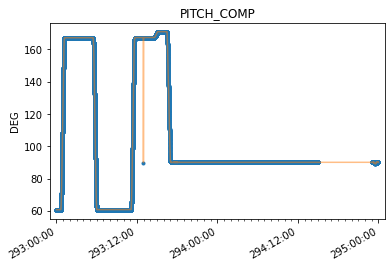

In [12]:
dat.plot('.')
dat.plot('-', alpha=0.5);

In [13]:
del os.environ["CHETA_FETCH_DATA_GAP"]

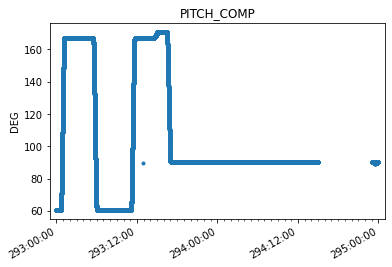

In [14]:
dat = fetch.Msid("pitch_comp", "2022:293:00:00:00", "2022:295:00:00:00.000")
dat.plot('.')

## Main code

In [15]:
Validate.subclasses


[kadi.commands.validate.ValidatePitch,
 kadi.commands.validate.ValidateRoll,
 kadi.commands.validate.ValidateDither,
 kadi.commands.validate.ValidatePcadMode,
 kadi.commands.validate.ValidateSimpos,
 kadi.commands.validate.ValidateObsid,
 kadi.commands.validate.ValidateLETG,
 kadi.commands.validate.ValidateHETG]

### Pitch

In [16]:
vp = ValidatePitch(stop="2022:295:18:00:00", days=3.0)

In [17]:
vp.tlm

time,pitch_comp
float64,float64
782589669.925,167.15916846487335
782589670.9499999,167.15915204270962
782589671.9749999,167.15910891821767
782589672.9999999,167.15910259571464
782589674.025,167.15907774016787
782589675.05,167.1590627687935
782589676.0749999,167.15904721547045
782589677.0999999,167.15904222026435
782589678.1249999,167.1590218511764


In [18]:
vp.tlm_vals

167.15916846487335
167.15915204270962
167.15910891821767
167.15910259571464
167.15907774016787
167.1590627687935
167.15904721547045
167.15904222026435
167.1590218511764
167.15898297866076
167.15895073665322


In [19]:
vp.states

datestart,datestop,tstart,tstop,pitch,pcad_mode,trans_keys
str21,str21,float64,float64,float64,str4,object
2022:292:18:00:00.731,2022:292:18:05:30.816,782589669.915,782590000.0,167.25861725790938,NPNT,
2022:292:18:05:30.816,2022:292:19:48:21.394,782590000.0,782596170.578,167.2914203503193,NPNT,pitch
2022:292:19:48:21.394,2022:292:19:48:31.645,782596170.578,782596180.829,167.2914203503193,NMAN,pcad_mode
2022:292:19:48:31.645,2022:292:19:53:29.184,782596180.829,782596478.368,165.08240098621297,NMAN,pitch
2022:292:19:53:29.184,2022:292:19:58:26.723,782596478.368,782596775.907,155.13455517304158,NMAN,pitch
2022:292:19:58:26.723,2022:292:20:03:24.262,782596775.907,782597073.446,136.32709333662703,NMAN,pitch
2022:292:20:03:24.262,2022:292:20:08:21.800,782597073.446,782597370.984,114.09684025166052,NMAN,pitch
2022:292:20:08:21.800,2022:292:20:13:19.339,782597370.984,782597668.523,91.86849678343202,NMAN,pitch
2022:292:20:13:19.339,2022:292:20:18:16.878,782597668.523,782597966.062,73.05897371143362,NMAN,pitch


In [20]:
vp.state_vals

167.25861725790938
167.25861725790938
167.25861725790938
167.25861725790938
167.25861725790938
167.25861725790938
167.25861725790938
167.25861725790938
167.25861725790938
167.25861725790938
167.25861725790938


In [21]:
fig = vp.get_plot_figure()
fig.show()

In [22]:
html = vp.get_plot_html(show=True)

In [23]:
len(html)

56012

#### Getting HTML for a single state

This hints at the way that other applications (`acis_thermal_check` hint hint) could
use this.

See `validate.get_index_page_html()` function.

In [24]:
from IPython.display import HTML

In [25]:
html = vp.get_html()
Path('validate_pitch.html').write_text(html)

58084

In [26]:
!open validate_pitch.html

### Infrastructure: compressing large time-series plots for plotly

Down-side of interactive plots in `plotly` is that the HTML source
can get huge for more than around 100,000 points. 

I probably re-invented a wheel here, but I wrote code to split a
time series into chunks where the value is constant to within a tolerance.
There is also an option to never let a chunk get longer than a certain duration.

In [27]:
print(len(vp.tlm_vals))

432924


In [28]:
chunks = get_time_series_chunks(vp.tlm["time"], vp.tlm_vals, max_delta_time=None, max_delta_val=2.0)
print(len(chunks))
chunks[:3]

261


[<TimeSeriesChunk
 first=<TimeSeriesPoint date=2022:292:18:00:00.741 val=167.15916846487335>
 min=<TimeSeriesPoint date=2022:292:19:52:00.641 val=165.19780816657226>
 max=<TimeSeriesPoint date=2022:292:19:42:13.316 val=167.18130025270034>
 last=<TimeSeriesPoint date=2022:292:19:52:00.641 val=165.19780816657226>>,
 <TimeSeriesChunk
 first=<TimeSeriesPoint date=2022:292:19:52:00.641 val=165.19780816657226>
 min=<TimeSeriesPoint date=2022:292:19:53:14.441 val=163.22814022246394>
 max=<TimeSeriesPoint date=2022:292:19:52:00.641 val=165.19780816657226>
 last=<TimeSeriesPoint date=2022:292:19:53:14.441 val=163.22814022246394>>,
 <TimeSeriesChunk
 first=<TimeSeriesPoint date=2022:292:19:53:14.441 val=163.22814022246394>
 min=<TimeSeriesPoint date=2022:292:19:54:10.816 val=161.2661542309357>
 max=<TimeSeriesPoint date=2022:292:19:53:14.441 val=163.22814022246394>
 last=<TimeSeriesPoint date=2022:292:19:54:10.816 val=161.2661542309357>>]

In [29]:
times, vals = compress_time_series(vp.tlm["time"], vp.tlm_vals, max_delta_val=2.0)

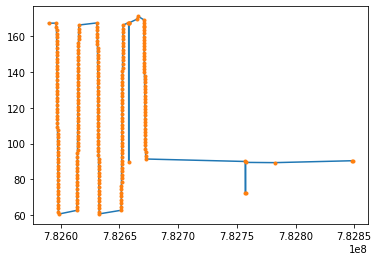

In [30]:
plt.plot(times, vals, "C0")
plt.plot(times, vals, "C1.")

In [31]:
vp.get_plot_figure().show()

## Dither

In [32]:
vd = ValidateDither(stop="2022:297", days=7)

In [33]:
html = vd.get_plot_html(show=True)

In [34]:
vt = ValidateSimpos(stop="2022:296", days=4)

In [35]:
html = vt.get_plot_html(show=True)

## Obsid

In [36]:
vo = ValidateObsid(stop="2022:300", days=7)
fig = vo.get_plot_figure()
fig.show()

In [37]:
out = vo.get_plot_html(show=True)

### Playing: making gaps in plotly

In [38]:
x = CxoTime(["2022:001", "2022:002", "2022:003" ,"2022:004", "2022:005"]).datetime64
y = [1, 2, np.nan, 2, 4]
hovertemplate = "%{x|%Y:%j:%H:%M:%S} %{y}"

fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=y, mode="lines", hovertemplate=hovertemplate))
fig.show()


In [39]:
dat = fetch.Msid('tephin', '2022:001', '2022:002')